<a href="https://colab.research.google.com/github/raghavgate/Machine-Learning-and-Artificial-Intelligence-Projects/blob/main/Neural-Networks/Neural_Net_for_Handwritten_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 4 Neural Networks for Handwritten Digit Recognition and Decision Trees

In this exercise, you will use a neural network to recognize the hand-written digits 0-9. Then you will implement a decision tree from scratch and apply it to the task of classifying whether a mushroom is edible or poisonous.


# Outline
- [ 1 - Packages ](#1)
- [ 2 - ReLU Activation](#2)
- [ 3 - Softmax Function](#3)
  - [ Exercise 1](#ex01)
- [ 4 - Neural Networks](#4)
  - [ 4.1 Problem Statement](#4.1)
  - [ 4.2 Dataset](#4.2)
  - [ 4.3 Model representation](#4.3)
  - [ 4.4 Tensorflow Model Implementation](#4.4)
  - [ 4.5 Softmax placement](#4.5)
    - [ Exercise 2](#ex02)
- [ 5 -  Decision Tree](#5)
- [ 6 - Dataset](#6)
  - [ 6.1 One hot encoded dataset](#6.1)
- [ 7 - Decision Tree Refresher](#7)
  - [ 7.1  Calculate entropy](#7.1)
    - [ Exercise 3](#ex03)
  - [ 7.2  Split dataset](#7.2)
    - [ Exercise 4](#ex04)
  - [ 7.3  Calculate information gain](#7.3)
    - [ Exercise 5](#ex05)
  - [ 7.4  Get best split](#7.4)
    - [ Exercise 6](#ex06)
- [ 8 - Building the tree](#8)

<a name="1"></a>
## 1 - Packages

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [3]:
!git clone https://github.com/M-Eng-Intro-to-ML/hw4.git
%cd hw4

Cloning into 'hw4'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 6.94 MiB | 7.16 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/hw4


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

from public_tests import *

from autils import *
from lab_utils_softmax import plt_softmax
np.set_printoptions(precision=2)

/content/hw4/public_tests.py:116: SyntaxWarning: invalid escape sequence '\{'
  assert np.allclose(right, expected['right']) and np.allclose(left, expected['left']), f"Wrong value when target is at index 0. \nExpected: {expected} \ngot: \{left:{left}, 'right': {right}\}"
/content/hw4/public_tests.py:116: SyntaxWarning: invalid escape sequence '\}'
  assert np.allclose(right, expected['right']) and np.allclose(left, expected['left']), f"Wrong value when target is at index 0. \nExpected: {expected} \ngot: \{left:{left}, 'right': {right}\}"


<a name="2"></a>
## 2 - ReLU Activation
We introduced a new activation in the class, the Rectified Linear Unit (ReLU).
$$ a = max(0,z) \quad\quad\text {# ReLU function} $$

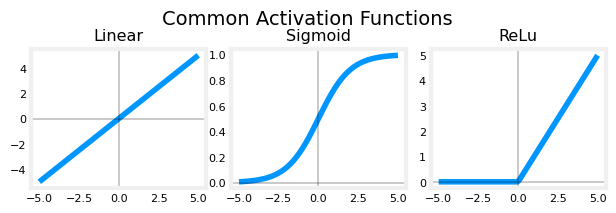

In [5]:
plt_act_trio()

<a name="3"></a>
## 3 - Softmax Function
A multiclass neural network generates N outputs. One output is selected as the predicted answer. In the output layer, a vector $\mathbf{z}$ is generated by a linear function which is fed into a softmax function. The softmax function converts $\mathbf{z}$  into a probability distribution as described below. After applying softmax, each output will be between 0 and 1 and the outputs will sum to 1. They can be interpreted as probabilities. The larger inputs to the softmax will correspond to larger output probabilities.

The softmax function can be written:
$$a_j = \frac{e^{z_j}}{ \sum_{k=0}^{N-1}{e^{z_k} }} \tag{1}$$

Where $z = \mathbf{w} \cdot \mathbf{x} + b$ and N is the number of feature/categories in the output layer.  

<a name="ex01"></a>
### Exercise 1
Let's create a NumPy implementation:

In [6]:
# UNQ_1
# GRADED CELL: my_softmax

def my_softmax(z):
    """ Softmax converts a vector of values to a probability distribution.
    Args:
      z (ndarray (N,))  : input data, N features
    Returns:
      a (ndarray (N,))  : softmax of z
    """
    ### START CODE HERE ###
    ez = np.exp(z)
    a = ez / np.sum(ez)
    ### END CODE HERE ###
    return a

In [7]:
z = np.array([1., 2., 3., 4.])
a = my_softmax(z)
atf = tf.nn.softmax(z)
print(f"my_softmax(z):         {a}")
print(f"tensorflow softmax(z): {atf}")

# BEGIN UNIT TEST
test_my_softmax(my_softmax)
# END UNIT TEST

my_softmax(z):         [0.03 0.09 0.24 0.64]
tensorflow softmax(z): [0.03 0.09 0.24 0.64]
 All tests passed.


<a name="4"></a>
## 4 - Neural Networks

In this section you will implement a neural network with multiclass classification. This will utilize the softmax activation.


<a name="4.1"></a>
### 4.1 Problem Statement

In this exercise, you will use a neural network to recognize ten handwritten digits, 0-9. This is a multiclass classification task where one of n choices is selected. Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks.


<a name="4.2"></a>
### 4.2 Dataset

You will start by loading the dataset for this task.
- The `load_data()` function shown below loads the data into variables `X` and `y`


- The data set contains 5000 training examples of handwritten digits $^1$.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit.
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location.
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.
        - Each training examples becomes a single row in our data matrix `X`.
        - This gives us a 5000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X =
\left(\begin{array}{cc}
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\
--- (x^{(m)}) ---
\end{array}\right)$$

- The second part of the training set is a 5000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 4` if the image is of the digit `4` and so on.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [8]:
# load dataset
X, y = load_data()

#### 4.2.1 View the variables
Let's get more familiar with your dataset.  
- A good place to start is to print out each variable and see what it contains.

The code below prints the first element in the variables `X` and `y`.  

In [9]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

In [10]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  9


#### 4.2.2 Check the dimensions of your variables

Another way to get familiar with your data is to view its dimensions. Please print the shape of `X` and `y` and see how many training examples you have in your dataset.

In [11]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


#### 4.2.3 Visualizing the Data

You will begin by visualizing a subset of the training set.
- In the cell below, the code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together.
- The label for each image is displayed above the image

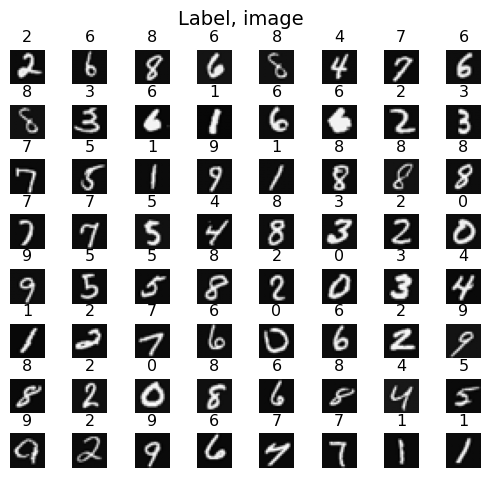

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

<a name="4.3"></a>
### 4.3 Model representation

The neural network you will use in this assignment is shown in the figure below.
- This has two dense layers with ReLU activations followed by an output layer with a linear activation.
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $10$ output units in layer 3, one for each digit.

    - Recall that the dimensions of these parameters is determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will be a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 10) and the shape of `b3` is: (10,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (n,1) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention:
               

<a name="4.4"></a>
### 4.4 Tensorflow Model Implementation


Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated for you. You specify a layer's *output dimensions* and this determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statement below.
>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:  
`tf.keras.Input(shape=(400,)),    #specify input shape`  
We will include that here to illuminate some model sizing.

<a name="4.5"></a>
### 4.5 Softmax placement
As described in the lecture and the optional softmax lab, numerical stability is improved if the softmax is grouped with the loss function rather than the output layer during training. This has implications when *building* the model and *using* the model.  
Building:  
* The final Dense layer should use a 'linear' activation. This is effectively no activation.
* The `model.compile` statement will indicate this by including `from_logits=True`.
`loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) `  
* This does not impact the form of the target. In the case of SparseCategorialCrossentropy, the target is the expected digit, 0-9.

Using the model:
* The outputs are not probabilities. If output probabilities are desired, apply a softmax function.

<a name="ex02"></a>
### Exercise 2

Below, using Keras [Sequential model](https://keras.io/guides/sequential_model/) and [Dense Layer](https://keras.io/api/layers/core_layers/dense/) with a ReLU activation to construct the three layer network described above.

In [13]:
# UNQ_2
# GRADED CELL: Sequential model
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [
        ### START CODE HERE ###
        tf.keras.Input(shape=(400,)),
        Dense(units=25, activation='relu', name='L1'),
        Dense(units=15, activation='relu', name='L2'),
        Dense(units=10, activation='linear', name='L3')
        ### END CODE HERE ###
    ], name = "my_model"
)

In [14]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 25)             │        10,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,575 (41.31 KB)

 Trainable params: 10,575 (41.31 KB)

 Non-trainable params: 0 (0.00 B)

<details>
  <summary><font size="3" color="darkgreen"><b>Expected Output (Click to expand)</b></font></summary>
The `model.summary()` function displays a useful summary of the model. Note, the names of the layers may vary as they are auto-generated unless the name is specified.    
    
```
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 25)                10025     
_________________________________________________________________
L2 (Dense)                   (None, 15)                390       
_________________________________________________________________
L3 (Dense)                   (None, 10)                160       
=================================================================
Total params: 10,575
Trainable params: 10,575
Non-trainable params: 0
_________________________________________________________________
```

In [15]:
# BEGIN UNIT TEST
test_model(model, 10, 400)
# END UNIT TEST

All tests passed!


The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

Let's further examine the weights to verify that tensorflow produced the same dimensions as we calculated above.

In [16]:
[layer1, layer2, layer3] = model.layers

In [17]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


**Expected Output**
```
W1 shape = (400, 25), b1 shape = (25,)  
W2 shape = (25, 15), b2 shape = (15,)  
W3 shape = (15, 10), b3 shape = (10,)
```

The following code:
* defines a loss function, `SparseCategoricalCrossentropy` and indicates the softmax should be included with the  loss calculation by adding `from_logits=True`)
* defines an optimizer. A popular choice is Adaptive Moment (Adam) which was described in lecture.

In [18]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9109
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6196
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3984
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3238
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2821
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2530
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2302
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2110
Epoch 9/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1952
Epoch 10/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1815
Epoch 11/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1698
Epoch 12/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1591
Epoch 13/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1499
Epoch 14/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1411
Epoch 15/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

#### Epochs and batches
In the `compile` statement above, the number of `epochs` was set to 100. This specifies that the entire data set should be applied during training 100 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/100
157/157 [==============================] - 0s 1ms/step - loss: 2.2770
```
The first line, `Epoch 1/100`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 5000 examples in our data set or roughly 157 batches. The notation on the 2nd line `157/157 [====` is describing which batch has been executed.

#### Loss  (cost)
In course 1, we learned to track the progress of gradient descent by monitoring the cost. Ideally, the cost will decrease as the number of iterations of the algorithm increases. Tensorflow refers to the cost as `loss`. Above, you saw the loss displayed each epoch as `model.fit` was executing. The [.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model) method returns a variety of metrics including the loss. This is captured in the `history` variable above. This can be used to examine the loss in a plot as shown below.

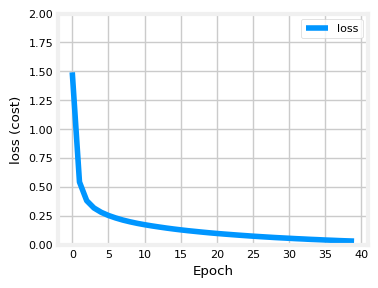

In [19]:
plot_loss_tf(history)

#### Prediction
To make a prediction, use Keras `predict`. Below, X[1015] contains an image of a two.

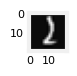

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
 predicting a Two: 
[[-14.79  -0.32   2.26  -2.61 -19.56  -9.42 -11.09  -2.35 -11.28 -13.19]]
 Largest Prediction index: 2


In [20]:
image_of_two = X[1015]
display_digit(image_of_two)

prediction = model.predict(image_of_two.reshape(1,400))  # prediction

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

The largest output is prediction[2], indicating the predicted digit is a '2'. If the problem only requires a selection, that is sufficient. Use NumPy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to select it. If the problem requires a probability, a softmax is required:

In [21]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 predicting a Two. Probability vector: 
[[3.62e-08 6.94e-02 9.14e-01 7.03e-03 3.05e-10 7.77e-06 1.46e-06 9.09e-03
  1.20e-06 1.79e-07]]
Total of predictions: 1.000


To return an integer representing the predicted target, you want the index of the largest probability. This is accomplished with the Numpy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function.

In [22]:
yhat = np.argmax(prediction_p)

print(f"np.argmax(prediction_p): {yhat}")

np.argmax(prediction_p): 2


Let's compare the predictions vs the labels for a random sample of 64 digits. This takes a moment to run.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

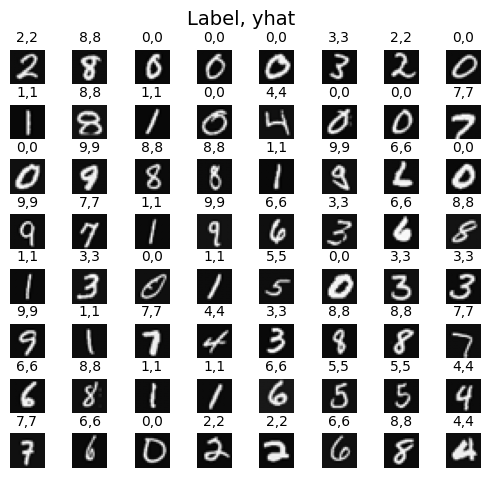

In [23]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)

    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

Let's look at some of the errors.
>Note: increasing the number of training epochs can eliminate the errors on this data set.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
23 errors out of 5000 images


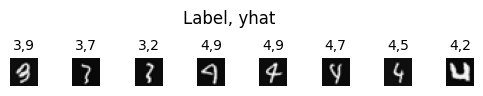

In [24]:
print( f"{display_errors(model,X,y)} errors out of {len(X)} images")

Let's take a look at the mode's parameter on the first layer. As each unit has the same number of coefficients as the input images, their dimension matches the 20x20.

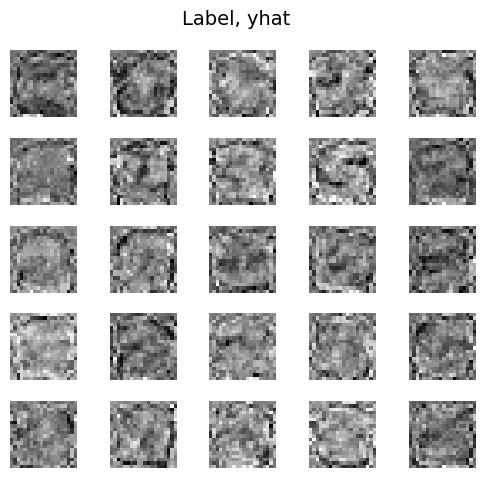

In [25]:
W1, b1 = model.layers[0].get_weights()

m, n = X.shape

fig, axes = plt.subplots(5,5, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = W1[:,i].reshape((20,20)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network

    # Display the label above the image
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

<a name="5"></a>
## 5 -  Decision Tree

Suppose you are starting a company that grows and sells wild mushrooms.
- Since not all mushrooms are edible, you'd like to be able to tell whether a given mushroom is edible or poisonous based on it's physical attributes
- You have some existing data that you can use for this task.

Can you use the data to help you identify which mushrooms can be sold safely?

Note: The dataset used is for illustrative purposes only. It is not meant to be a guide on identifying edible mushrooms.



<a name="6"></a>
## 6 - Dataset

You will start by loading the dataset for this task. The dataset you have collected is as follows:

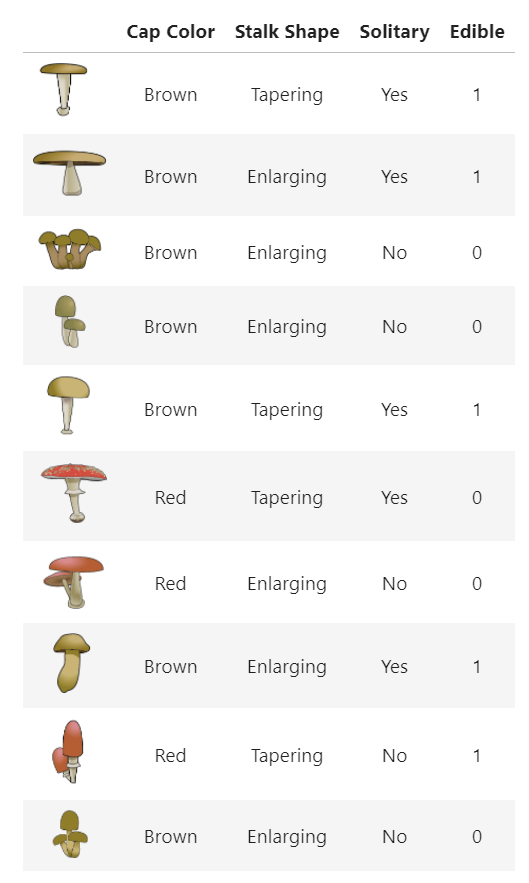


-  You have 10 examples of mushrooms. For each example, you have
    - Three features
        - Cap Color (`Brown` or `Red`),
        - Stalk Shape (`Tapering (as in \/)` or `Enlarging (as in /\)`), and
        - Solitary (`Yes` or `No`)
    - Label
        - Edible (`1` indicating yes or `0` indicating poisonous)

<a name="6.1"></a>
### 6.1 One hot encoded dataset
For ease of implementation, we have one-hot encoded the features (turned them into 0 or 1 valued features)

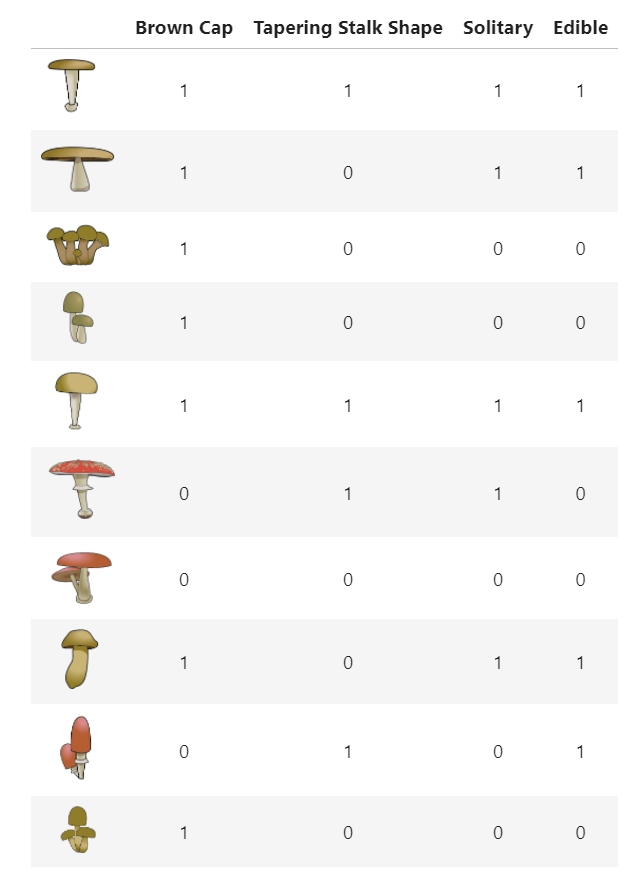
Therefore,
- `X_train` contains three features for each example
    - Brown Color (A value of `1` indicates "Brown" cap color and `0` indicates "Red" cap color)
    - Tapering Shape (A value of `1` indicates "Tapering Stalk Shape" and `0` indicates "Enlarging" stalk shape)
    - Solitary  (A value of `1` indicates "Yes" and `0` indicates "No")

- `y_train` is whether the mushroom is edible
    - `y = 1` indicates edible
    - `y = 0` indicates poisonous

In [26]:
X_train = np.array([[1,1,1],[1,0,1],[1,0,0],[1,0,0],[1,1,1],[0,1,1],[0,0,0],[1,0,1],[0,1,0],[1,0,0]])
y_train = np.array([1,1,0,0,1,0,0,1,1,0])

#### View the variables
Let's get more familiar with your dataset.  
- A good place to start is to just print out each variable and see what it contains.

The code below prints the first few elements of `X_train` and the type of the variable.

In [27]:
print("First few elements of X_train:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First few elements of X_train:
 [[1 1 1]
 [1 0 1]
 [1 0 0]
 [1 0 0]
 [1 1 1]]
Type of X_train: <class 'numpy.ndarray'>


Now, let's do the same for `y_train`

In [28]:
print("First few elements of y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

First few elements of y_train: [1 1 0 0 1]
Type of y_train: <class 'numpy.ndarray'>


#### Check the dimensions of your variables

Another useful way to get familiar with your data is to view its dimensions.

Please print the shape of `X_train` and `y_train` and see how many training examples you have in your dataset.

In [29]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of y_train is: ', y_train.shape)
print ('Number of training examples (m):', len(X_train))

The shape of X_train is: (10, 3)
The shape of y_train is:  (10,)
Number of training examples (m): 10


<a name="7"></a>
## 7 - Decision Tree Refresher

In this practice lab, you will build a decision tree based on the dataset provided.

- Recall that the steps for building a decision tree are as follows:
    - Start with all examples at the root node
    - Calculate information gain for splitting on all possible features, and pick the one with the highest information gain
    - Split dataset according to the selected feature, and create left and right branches of the tree
    - Keep repeating splitting process until stopping criteria is met
  
  
- In this lab, you'll implement the following functions, which will let you split a node into left and right branches using the feature with the highest information gain
    - Calculate the entropy at a node
    - Split the dataset at a node into left and right branches based on a given feature
    - Calculate the information gain from splitting on a given feature
    - Choose the feature that maximizes information gain
    
- We'll then use the helper functions you've implemented to build a decision tree by repeating the splitting process until the stopping criteria is met
    - For this lab, the stopping criteria we've chosen is setting a maximum depth of 2

<a name="7.1"></a>
### 7.1  Calculate entropy

First, you'll write a helper function called `compute_entropy` that computes the entropy (measure of impurity) at a node.
- The function takes in a numpy array (`y`) that indicates whether the examples in that node are edible (`1`) or poisonous(`0`)

Complete the `compute_entropy()` function below to:
* Compute $p_1$, which is the fraction of examples that are edible (i.e. have value = `1` in `y`)
* The entropy is then calculated as

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$
* Note
    * The log is calculated with base $2$
    * For implementation purposes, $0\text{log}_2(0) = 0$. That is, if `p_1 = 0` or `p_1 = 1`, set the entropy to `0`
    * Make sure to check that the data at a node is not empty (i.e. `len(y) != 0`). Return `0` if it is
    


<a name="ex03"></a>
### Exercise 3

Please complete the `compute_entropy()` function using the previous instructions.

In [32]:
# UNQ_3
# GRADED FUNCTION: compute_entropy

def compute_entropy(y):
    """
    Computes the entropy for

    Args:
       y (ndarray): Numpy array indicating whether each example at a node is
           edible (`1`) or poisonous (`0`)

    Returns:
        entropy (float): Entropy at that node

    """
    # You need to return the following variables correctly
    entropy = 0.

    ### START CODE HERE ###
    if len(y) == 0:
        return 0

    p1 = np.sum(y) / len(y)

    if p1 == 0 or p1 == 1:
        entropy = 0
    else:
        entropy = -p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1)
    ### END CODE HERE ###

    return entropy

You can check if your implementation was correct by running the following test code:

In [33]:
# Compute entropy at the root node (i.e. with all examples)
# Since we have 5 edible and 5 non-edible mushrooms, the entropy should be 1"

print("Entropy at root node: ", compute_entropy(y_train))

# UNIT TESTS
compute_entropy_test(compute_entropy)

Entropy at root node:  1.0
 All tests passed.


**Expected Output**:
<table>
  <tr>
    <td> <b>Entropy at root node:<b> 1.0 </td>
  </tr>
</table>

<a name="7.2"></a>
### 7.2  Split dataset

Next, you'll write a helper function called `split_dataset` that takes in the data at a node and a feature to split on and splits it into left and right branches. Later in the lab, you'll implement code to calculate how good the split is.

- The function takes in the training data, the list of indices of data points at that node, along with the feature to split on.
- It splits the data and returns the subset of indices at the left and the right branch.
- For example, say we're starting at the root node (so `node_indices = [0,1,2,3,4,5,6,7,8,9]`), and we chose to split on feature `0`, which is whether or not the example has a brown cap.
    - The output of the function is then, `left_indices = [0,1,2,3,4,7,9]` (data points with brown cap) and `right_indices = [5,6,8]` (data points without a brown cap)
    
    
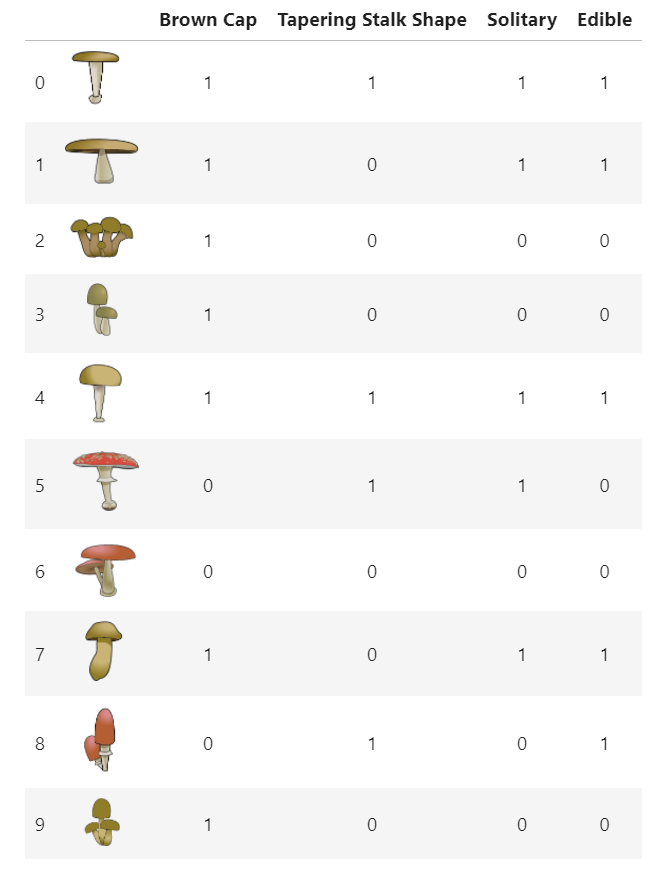





<a name="ex04"></a>
### Exercise 4

Please complete the `split_dataset()` function shown below

- For each index in `node_indices`
    - If the value of `X` at that index for that feature is `1`, add the index to `left_indices`
    - If the value of `X` at that index for that feature is `0`, add the index to `right_indices`

In [34]:
# UNQ_4
# GRADED FUNCTION: split_dataset

def split_dataset(X, node_indices, feature):
    """
    Splits the data at the given node into
    left and right branches

    Args:
        X (ndarray):             Data matrix of shape(n_samples, n_features)
        node_indices (list):     List containing the active indices. I.e, the samples being considered at this step.
        feature (int):           Index of feature to split on

    Returns:
        left_indices (list):     Indices with feature value == 1
        right_indices (list):    Indices with feature value == 0
    """

    # You need to return the following variables correctly
    left_indices = []
    right_indices = []

    ### START CODE HERE ###
    for i in node_indices:
        if X[i, feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
    ### END CODE HERE ###

    return left_indices, right_indices

Now, let's check your implementation using the code blocks below. Let's try splitting the dataset at the root node, which contains all examples at feature 0 (Brown Cap) as we'd discussed above. We've also provided a helper function to visualize the output of the split.

In [35]:
root_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Feel free to play around with these variables
# The dataset only has three features, so this value can be 0 (Brown Cap), 1 (Tapering Stalk Shape) or 2 (Solitary)
feature = 0

left_indices, right_indices = split_dataset(X_train, root_indices, feature)

print("Left indices: ", left_indices)
print("Right indices: ", right_indices)

# UNIT TESTS
split_dataset_test(split_dataset)

Left indices:  [0, 1, 2, 3, 4, 7, 9]
Right indices:  [5, 6, 8]
 All tests passed.


**Expected Output**:
```
Left indices:  [0, 1, 2, 3, 4, 7, 9]
Right indices:  [5, 6, 8]
```

<a name="7.3"></a>
### 7.3  Calculate information gain

Next, you'll write a function called `information_gain` that takes in the training data, the indices at a node and a feature to split on and returns the information gain from the split.

<a name="ex05"></a>
### Exercise 5

Please complete the `compute_information_gain()` function shown below to compute

$$\text{Information Gain} = H(p_1^\text{node})- (w^{\text{left}}H(p_1^\text{left}) + w^{\text{right}}H(p_1^\text{right}))$$

where
- $H(p_1^\text{node})$ is entropy at the node
- $H(p_1^\text{left})$ and $H(p_1^\text{right})$ are the entropies at the left and the right branches resulting from the split
- $w^{\text{left}}$ and $w^{\text{right}}$ are the proportion of examples at the left and right branch, respectively

Note:
- You can use the `compute_entropy()` function that you implemented above to calculate the entropy
- We've provided some starter code that uses the `split_dataset()` function you implemented above to split the dataset

In [36]:
# UNQ_5
# GRADED FUNCTION: compute_information_gain

def compute_information_gain(X, y, node_indices, feature):

    """
    Compute the information of splitting the node on a given feature

    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.

    Returns:
        cost (float):        Cost computed

    """
    # Split dataset
    left_indices, right_indices = split_dataset(X, node_indices, feature)

    # Some useful variables
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]

    # You need to return the following variables correctly
    information_gain = 0

    ### START CODE HERE ###
    node_entropy = compute_entropy(y_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)

    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)

    weighted_average_entropy = w_left * left_entropy + w_right * right_entropy

    information_gain = node_entropy - weighted_average_entropy
    ### END CODE HERE ###

    return information_gain

You can now check your implementation using the cell below and calculate what the information gain would be from splitting on each of the featues

In [37]:
info_gain0 = compute_information_gain(X_train, y_train, root_indices, feature=0)
print("Information Gain from splitting the root on brown cap: ", info_gain0)

info_gain1 = compute_information_gain(X_train, y_train, root_indices, feature=1)
print("Information Gain from splitting the root on tapering stalk shape: ", info_gain1)

info_gain2 = compute_information_gain(X_train, y_train, root_indices, feature=2)
print("Information Gain from splitting the root on solitary: ", info_gain2)

# UNIT TESTS
compute_information_gain_test(compute_information_gain)

Information Gain from splitting the root on brown cap:  0.034851554559677034
Information Gain from splitting the root on tapering stalk shape:  0.12451124978365313
Information Gain from splitting the root on solitary:  0.2780719051126377
 All tests passed.


**Expected Output**:
```
Information Gain from splitting the root on brown cap:  0.034851554559677034
Information Gain from splitting the root on tapering stalk shape:  0.12451124978365313
Information Gain from splitting the root on solitary:  0.2780719051126377
```

Splitting on "Solitary" (feature = 2) at the root node gives the maximum information gain. Therefore, it's the best feature to split on at the root node.

<a name="7.4"></a>
### 7.4  Get best split
Now let's write a function to get the best feature to split on by computing the information gain from each feature as we did above and returning the feature that gives the maximum information gain

<a name="ex06"></a>
### Exercise 6
Please complete the `get_best_split()` function shown below.
- The function takes in the training data, along with the indices of datapoint at that node
- The output of the function is the feature that gives the maximum information gain
    - You can use the `compute_information_gain()` function to iterate through the features and calculate the information for each feature

In [41]:
# UNQ_6
# GRADED FUNCTION: get_best_split

def get_best_split(X, y, node_indices):
    """
    Returns the optimal feature and threshold value
    to split the node data

    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.

    Returns:
        best_feature (int):     The index of the best feature to split
    """

    # Some useful variables
    num_features = X.shape[1]

    # You need to return the following variables correctly
    best_feature = -1
    max_info_gain = 0.0  # Changed initialization from -1.0 to 0.0

    ### START CODE HERE ###
    for feature in range(num_features):
        info_gain = compute_information_gain(X, y, node_indices, feature)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_feature = feature
    ### END CODE HERE ###

    return best_feature

Now, let's check the implementation of your function using the cell below.

In [42]:
best_feature = get_best_split(X_train, y_train, root_indices)
print("Best feature to split on: %d" % best_feature)

# UNIT TESTS
get_best_split_test(get_best_split)

Best feature to split on: 2
 All tests passed.


As we saw above, the function returns that the best feature to split on at the root node is feature 2 ("Solitary")

<a name="8"></a>
## 8 - Building the tree

In this section, we use the functions you implemented above to generate a decision tree by successively picking the best feature to split on until we reach the stopping criteria (maximum depth is 2).

You do not need to implement anything for this part.

In [43]:
# Not graded
tree = []

def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth):
    """
    Build a tree using the recursive algorithm that split the dataset into 2 subgroups at each node.
    This function just prints the tree.

    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        branch_name (string):   Name of the branch. ['Root', 'Left', 'Right']
        max_depth (int):        Max depth of the resulting tree.
        current_depth (int):    Current depth. Parameter used during recursive call.

    """

    # Maximum depth reached - stop splitting
    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return

    # Otherwise, get best split and split the data
    # Get the best feature and threshold at this node
    best_feature = get_best_split(X, y, node_indices)

    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))

    # Split the dataset at the best feature
    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))

    # continue splitting the left and the right child. Increment current depth
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1)

In [44]:
build_tree_recursive(X_train, y_train, root_indices, "Root", max_depth=2, current_depth=0)

 Depth 0, Root: Split on feature: 2
- Depth 1, Left: Split on feature: 0
  -- Left leaf node with indices [0, 1, 4, 7]
  -- Right leaf node with indices [5]
- Depth 1, Right: Split on feature: 1
  -- Left leaf node with indices [8]
  -- Right leaf node with indices [2, 3, 6, 9]
